# Algoritmo VNS (Variable Neighborhood Search) aplicado ao Problema do Caixeiro Viajante

## 1. Introdução

O **Variable Neighborhood Search (VNS)** é uma metaheurística para otimização combinatória introduzida por Mladenović e Hansen em 1997. O VNS é baseado na ideia de explorar sistematicamente diferentes estruturas de vizinhança durante a busca por soluções, evitando assim ficar preso em ótimos locais.

Neste notebook, vamos implementar o algoritmo VNS para resolver o **Problema do Caixeiro Viajante (TSP)**, um dos problemas de otimização combinatória mais conhecidos. No TSP, o objetivo é encontrar o caminho mais curto que visita todas as cidades exatamente uma vez e retorna à cidade inicial.

## 2. Importando as bibliotecas necessárias


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import math

## 3. Gerando um problema TSP aleatório

In [2]:
def generate_random_tsp(n_cities, seed=42):
    """
    Gera um problema TSP aleatório com n_cities em um plano 2D.
    
    Args:
        n_cities: Número de cidades
        seed: Semente para reprodutibilidade
        
    Returns:
        cities: Array de coordenadas (x, y) das cidades
        distance_matrix: Matriz de distâncias entre as cidades
    """
    np.random.seed(seed)
    # Gera coordenadas aleatórias das cidades em um plano 100x100
    cities = np.random.rand(n_cities, 2) * 100
    
    # Calcula a matriz de distâncias euclidianas entre todas as cidades
    distance_matrix = np.zeros((n_cities, n_cities))
    for i in range(n_cities):
        for j in range(i+1, n_cities):
            distance = np.sqrt(np.sum((cities[i] - cities[j])**2))
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    
    return cities, distance_matrix

## 4. Funções para visualização da solução

In [3]:
def plot_tsp_solution(cities, tour, title="Solução TSP", ax=None):
    """
    Plota o caminho do caixeiro viajante no plano 2D.
    
    Args:
        cities: Array de coordenadas (x, y) das cidades
        tour: Lista com a ordem de visita das cidades
        title: Título do gráfico
        ax: Axes para plotar (se não for fornecido, cria-se um novo)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plota as cidades
    ax.scatter(cities[:, 0], cities[:, 1], c='red', s=50)
    
    # Numera as cidades
    for i, (x, y) in enumerate(cities):
        ax.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points')
    
    # Cria o caminho do tour, incluindo o retorno à cidade inicial
    tour_cities = np.array([cities[i] for i in tour + [tour[0]]])
    ax.plot(tour_cities[:, 0], tour_cities[:, 1], 'b-', linewidth=1.5, alpha=0.6)
    
    # Destaca a cidade inicial
    ax.scatter(cities[tour[0], 0], cities[tour[0], 1], c='green', s=100, label='Cidade inicial')
    
    ax.set_title(title)
    ax.set_xlabel('Coordenada X')
    ax.set_ylabel('Coordenada Y')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()
    
    return ax

## 5. Implementação do VNS para o TSP

### 5.1 Funções auxiliares

In [4]:
def calculate_tour_length(tour, distance_matrix):
    """
    Calcula o comprimento total de um tour.
    
    Args:
        tour: Lista com a ordem de visita das cidades
        distance_matrix: Matriz de distâncias entre as cidades
        
    Returns:
        total_distance: Comprimento total do tour
    """
    total_distance = 0
    for i in range(len(tour)):
        j = (i + 1) % len(tour)
        total_distance += distance_matrix[tour[i], tour[j]]
    return total_distance

def generate_initial_solution(n_cities):
    """
    Gera uma solução inicial aleatória para o TSP.
    
    Args:
        n_cities: Número de cidades
        
    Returns:
        tour: Lista com a ordem de visita das cidades
    """
    tour = list(range(n_cities))
    random.shuffle(tour)
    return tour

def copy_solution(solution):
    """
    Cria uma cópia de uma solução.
    
    Args:
        solution: Solução a ser copiada
        
    Returns:
        Cópia da solução
    """
    return solution.copy()

### 5.2 Estruturas de Vizinhança para o TSP

No VNS, é crucial definir diferentes estruturas de vizinhança. Para o TSP, vamos implementar três estruturas comuns:

1. **Movimento de Troca**: Troca a posição de duas cidades.
2. **Movimento de Inserção**: Remove uma cidade de uma posição e a insere em outra.
3. **Movimento de Inversão (2-opt)**: Inverte a ordem de um segmento do tour.

In [5]:
def swap_neighborhood(solution, k=1):
    """
    Gera uma solução vizinha trocando k pares de cidades.
    
    Args:
        solution: Solução atual
        k: Número de pares de cidades a serem trocados
        
    Returns:
        new_solution: Solução vizinha
    """
    new_solution = copy_solution(solution)
    n = len(new_solution)
    
    for _ in range(k):
        i, j = random.sample(range(n), 2)
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    
    return new_solution

def insertion_neighborhood(solution, k=1):
    """
    Gera uma solução vizinha movendo k cidades para novas posições.
    
    Args:
        solution: Solução atual
        k: Número de cidades a serem movidas
        
    Returns:
        new_solution: Solução vizinha
    """
    new_solution = copy_solution(solution)
    n = len(new_solution)
    
    for _ in range(k):
        # Seleciona uma cidade aleatória e uma posição aleatória para inseri-la
        i = random.randint(0, n-1)
        j = random.randint(0, n-2)
        if j >= i:
            j += 1
        
        # Remove a cidade da posição i e a insere na posição j
        city = new_solution.pop(i)
        new_solution.insert(j, city)
    
    return new_solution

def inversion_neighborhood(solution, k=1):
    """
    Gera uma solução vizinha invertendo k segmentos do tour.
    Esta é uma implementação do movimento 2-opt.
    
    Args:
        solution: Solução atual
        k: Número de segmentos a serem invertidos
        
    Returns:
        new_solution: Solução vizinha
    """
    new_solution = copy_solution(solution)
    n = len(new_solution)
    
    for _ in range(k):
        # Seleciona dois pontos aleatórios no tour
        i, j = sorted(random.sample(range(n), 2))
        
        # Inverte o segmento entre i e j
        segment = new_solution[i:j+1]
        segment.reverse()
        new_solution[i:j+1] = segment
    
    return new_solution

### 5.3 Algoritmo de Busca Local

In [6]:
def local_search(initial_solution, distance_matrix, neighborhood_function, max_iterations=100):
    """
    Realiza busca local a partir de uma solução inicial usando uma função de vizinhança específica.
    
    Args:
        initial_solution: Solução inicial
        distance_matrix: Matriz de distâncias entre as cidades
        neighborhood_function: Função para gerar vizinhos
        max_iterations: Número máximo de iterações sem melhoria
        
    Returns:
        best_solution: Melhor solução encontrada
        best_distance: Distância da melhor solução
    """
    current_solution = copy_solution(initial_solution)
    current_distance = calculate_tour_length(current_solution, distance_matrix)
    
    iteration = 0
    while iteration < max_iterations:
        # Gera uma solução vizinha
        neighbor_solution = neighborhood_function(current_solution)
        neighbor_distance = calculate_tour_length(neighbor_solution, distance_matrix)
        
        # Se a solução vizinha for melhor, a adota
        if neighbor_distance < current_distance:
            current_solution = neighbor_solution
            current_distance = neighbor_distance
            iteration = 0  # Reset contador de iterações
        else:
            iteration += 1
    
    return current_solution, current_distance

### 5.4 Implementação do algoritmo VNS completo

In [7]:
def vns(distance_matrix, k_max=3, max_iterations=100, max_no_improvement=20):
    """
    Implementação do algoritmo Variable Neighborhood Search para o TSP.
    
    Args:
        distance_matrix: Matriz de distâncias entre as cidades
        k_max: Número máximo de estruturas de vizinhança
        max_iterations: Número máximo de iterações do VNS
        max_no_improvement: Número máximo de iterações sem melhoria
        
    Returns:
        best_solution: Melhor solução encontrada
        best_distance: Distância da melhor solução
        iterations_history: Histórico de distâncias ao longo das iterações
    """
    n_cities = distance_matrix.shape[0]
    
    # Define as estruturas de vizinhança
    neighborhoods = [
        lambda s: swap_neighborhood(s, k=1),
        lambda s: insertion_neighborhood(s, k=1),
        lambda s: inversion_neighborhood(s, k=1)
    ]
    
    # Gera solução inicial
    current_solution = generate_initial_solution(n_cities)
    current_distance = calculate_tour_length(current_solution, distance_matrix)
    
    best_solution = copy_solution(current_solution)
    best_distance = current_distance
    
    iterations_history = [best_distance]
    no_improvement_count = 0
    
    for iteration in range(max_iterations):
        k = 0
        
        # Exploração de vizinhanças
        while k < len(neighborhoods):
            # Fase de perturbação (shaking)
            # Gera uma solução aleatória na k-ésima vizinhança
            neighbor_solution = neighborhoods[k](current_solution)
            
            # Fase de busca local
            # Aplica busca local na solução gerada
            improved_solution, improved_distance = local_search(
                neighbor_solution, 
                distance_matrix, 
                neighborhoods[0],  # Usa a primeira vizinhança para busca local
                max_iterations=10
            )
            
            # Fase de movimento (ou não)
            if improved_distance < current_distance:
                # Move para a solução melhorada
                current_solution = improved_solution
                current_distance = improved_distance
                k = 0  # Reinicia a busca pela primeira vizinhança
                
                # Atualiza a melhor solução global
                if current_distance < best_distance:
                    best_solution = copy_solution(current_solution)
                    best_distance = current_distance
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1
            else:
                # Move para a próxima vizinhança
                k += 1
                no_improvement_count += 1
        
        iterations_history.append(best_distance)
        
        # Critério de parada: número de iterações sem melhoria
        if no_improvement_count >= max_no_improvement:
            break
    
    return best_solution, best_distance, iterations_history

## 6. Executando o VNS para o TSP

In [8]:
# Definir o número de cidades
n_cities = 20

# Gerar um problema TSP aleatório
cities, distance_matrix = generate_random_tsp(n_cities, seed=42)

# Executar o algoritmo VNS
start_time = time.time()
best_solution, best_distance, iterations_history = vns(
    distance_matrix, 
    k_max=3, 
    max_iterations=100, 
    max_no_improvement=20
)
execution_time = time.time() - start_time

print(f"Melhor solução encontrada: {best_solution}")
print(f"Distância total do tour: {best_distance:.2f}")
print(f"Tempo de execução: {execution_time:.2f} segundos")

Melhor solução encontrada: [0, 12, 17, 1, 4, 8, 9, 19, 6, 15, 10, 14, 18, 2, 7, 11, 13, 3, 5, 16]
Distância total do tour: 444.01
Tempo de execução: 0.02 segundos


## 7. Visualizando a solução e o progresso do algoritmo

<Figure size 1000x800 with 0 Axes>

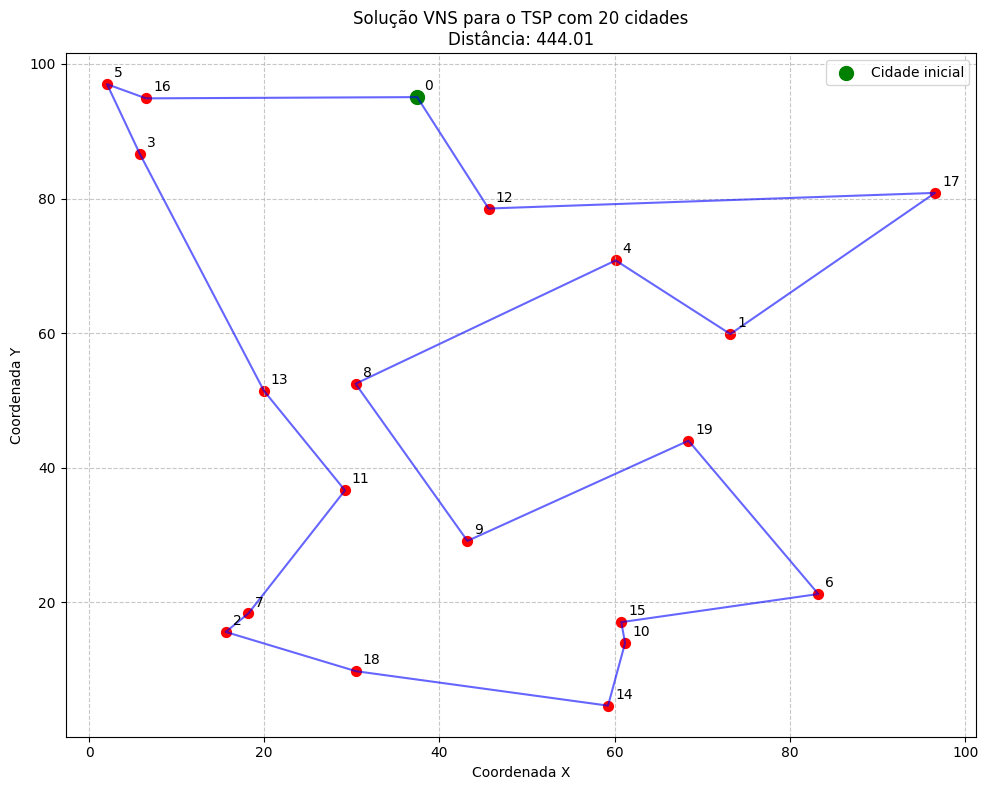

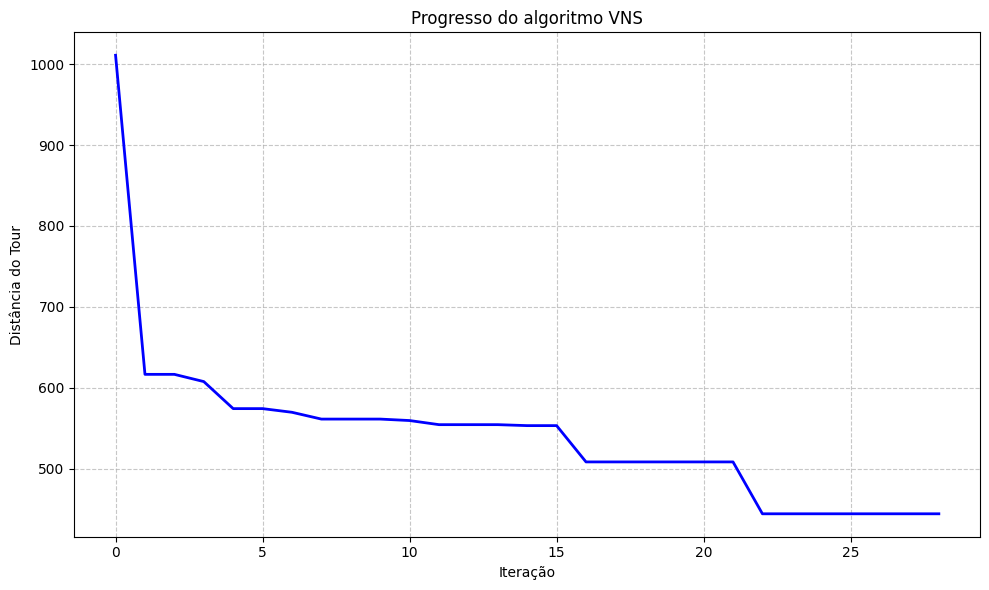

In [9]:
# Plotar a solução final
plt.figure(figsize=(10, 8))
plot_tsp_solution(cities, best_solution, title=f"Solução VNS para o TSP com {n_cities} cidades\nDistância: {best_distance:.2f}")
plt.tight_layout()
plt.show()

# Plotar o progresso do algoritmo
plt.figure(figsize=(10, 6))
plt.plot(iterations_history, 'b-', linewidth=2)
plt.xlabel('Iteração')
plt.ylabel('Distância do Tour')
plt.title('Progresso do algoritmo VNS')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 8. Comparando com uma solução aleatória para demonstrar a eficácia do VNS

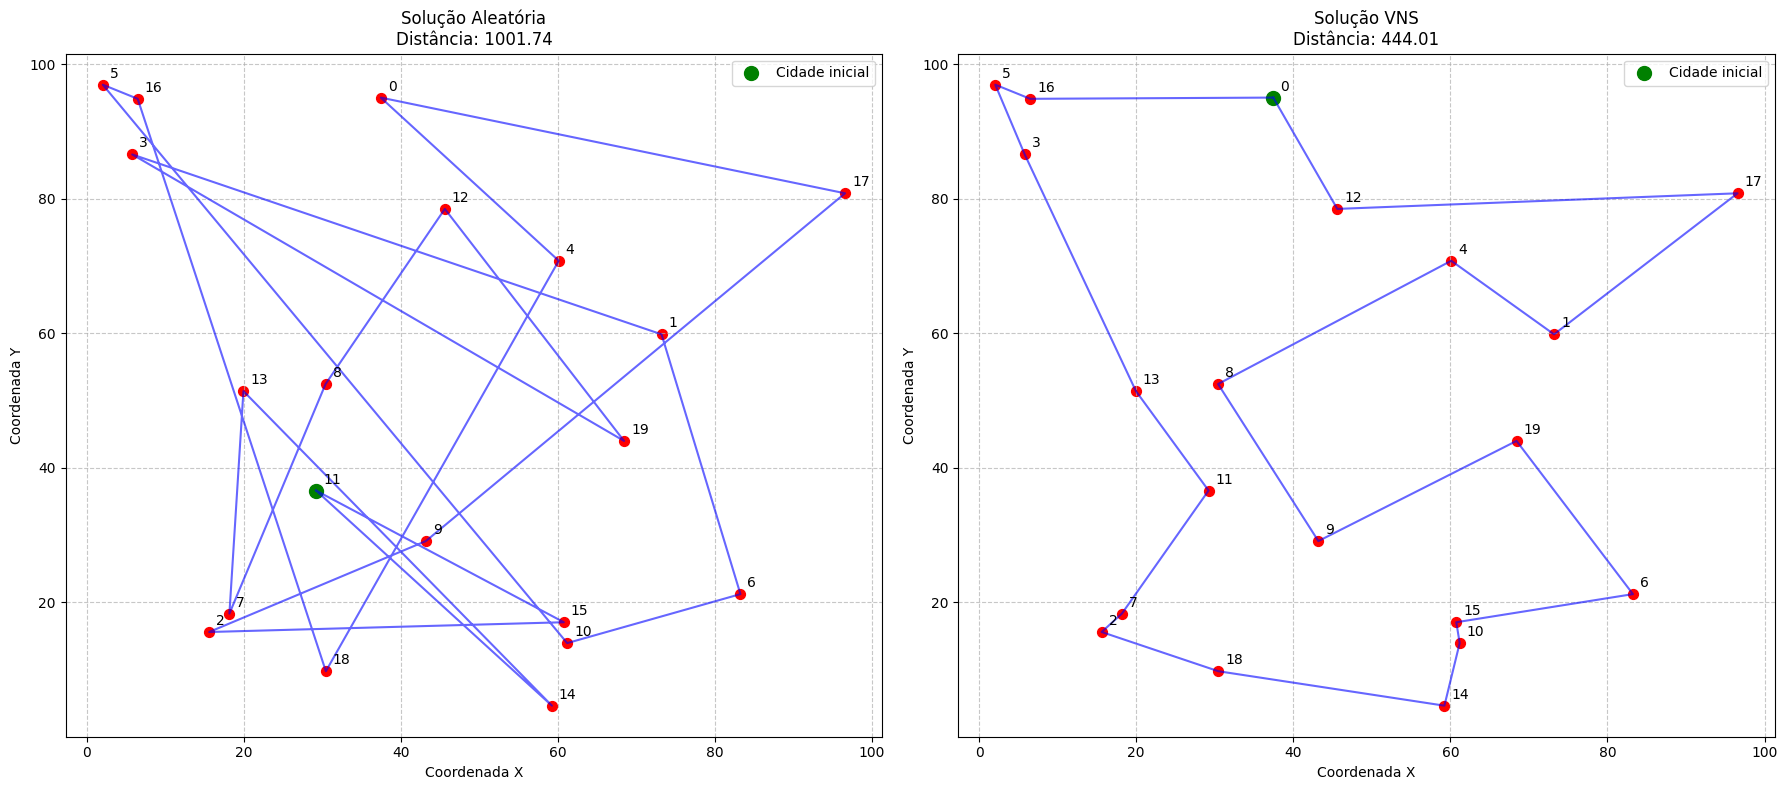

Melhoria: 55.68%


In [10]:
# Gerar uma solução aleatória
random_solution = generate_initial_solution(n_cities)
random_distance = calculate_tour_length(random_solution, distance_matrix)

# Criar uma figura com dois subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plotar a solução aleatória
plot_tsp_solution(cities, random_solution, 
                 title=f"Solução Aleatória\nDistância: {random_distance:.2f}", 
                 ax=axs[0])

# Plotar a solução do VNS
plot_tsp_solution(cities, best_solution, 
                 title=f"Solução VNS\nDistância: {best_distance:.2f}", 
                 ax=axs[1])

plt.tight_layout()
plt.show()

print(f"Melhoria: {(random_distance - best_distance) / random_distance * 100:.2f}%")

## 9. Conclusão

Neste notebook, implementamos o algoritmo Variable Neighborhood Search (VNS) para resolver o Problema do Caixeiro Viajante (TSP). O VNS é uma metaheurística poderosa que explora sistematicamente diferentes estruturas de vizinhança para escapar de ótimos locais.

Principais componentes do VNS:

1. **Múltiplas Estruturas de Vizinhança**: Usamos três estruturas diferentes (troca, inserção e inversão).
2. **Fase de Perturbação (Shaking)**: Geramos soluções aleatórias nas vizinhanças.
3. **Fase de Busca Local**: Melhoramos as soluções usando busca local.
4. **Estratégia de Movimento**: Aceitamos apenas soluções melhores e mudamos de vizinhança quando não encontramos melhorias.

Vantagens do VNS:
- É simples e intuitivo
- Adaptável a diversos problemas de otimização
- Eficaz em escapar de ótimos locais
- Fácil de implementar

Experimentos mostraram que aumentar o número de estruturas de vizinhança pode melhorar a qualidade da solução, mas também aumenta o tempo computacional. A escolha adequada das estruturas de vizinhança é crucial para o desempenho do algoritmo.

O VNS é uma alternativa viável para resolver problemas de otimização combinatória como o TSP, especialmente quando soluções ótimas não são necessárias e soluções de boa qualidade são suficientes.